# 시작

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
from IPython.display import display
import IPython
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
import os,sys
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

Mounted at /gdrive


# 개별함수

In [ ]:
def today():
  from datetime import datetime
  year = str(datetime.today().year)

  if datetime.today().month<10:
    month = str(0)+ str(datetime.today().month)
  else : month = str(datetime.today().month)

  if datetime.today().day<10:
    day = str(0)+ str(datetime.today().day)
  else : day = str(datetime.today().day)

  if (datetime.today().hour + 9)%24 < 10:
    hour = str(0)+ str((datetime.today().hour+9)%24)
  else : hour = str((datetime.today().hour+9)%24)

  if datetime.today().minute<10:
    min = str(0)+ str(datetime.today().minute)
  else : min = str(datetime.today().minute)


  return year+month+day+'_'+hour+'시'+min+'분'
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

def Directory(keyword):
  while True:
    try:
      base = '/gdrive/MyDrive/Colab Notebooks/Spotify Recommendation/Recommendation Models/'
      directory=base + keyword+'/'
      if not os.path.exists(directory):
            os.makedirs(directory)
            os.chdir(directory)
            return directory
            break
      else:
        os.chdir(directory)
        return directory
        break
    except OSError:
      print ('Error: Creating directory. ' +  directory)
      continue
  return directory

from collections import defaultdict
from sklearn.externals import joblib
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def Recommend(uid,top_n):
  if uid =='윤지현':
    print(f'<{uid} (a.k.a. 윤영롱) 님을 위한 추천곡>\n')
  else:
    print(f'<{uid} 님을 위한 추천곡>\n')
  for (iid,est) in top_n[uid]:
    print(f'{iid} => {round(round(est,4)*100,2)} %의 확률로 좋아하실 거에요')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Surprise 설치

In [ ]:
!pip install surprise
import surprise
from surprise import BaselineOnly 
from surprise import KNNWithMeans, KNNBaseline, KNNBasic, KNNWithZScore,CoClustering
from surprise import SVD,SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV


     |████████████████████████████████| 11.8MB 6.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617545 sha256=76832187a8ecd74f17a8c29c19ae6839fa1a869e0df5041fb559c70d2c08867c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# 데이터 불러오기 및 커스터마이징

In [ ]:
DATA_PATH = '/gdrive/Shareddrives/Spotify Recommendation/Spotify_Data.xlsx'
data_dict = pd.read_excel(DATA_PATH,sheet_name=None,header=0,index_col=0)
ratings = data_dict['Ratings']
tracks = data_dict['Track_Features']
display(ratings,tracks)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162
users,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
도윤,1,0,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,1
도윤_Herng,1,0,1,0,0,0,0,-1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,0,0,0,1,...,0,0,0,-1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,1,1,1
도윤__Melanie,-1,-1,-1,-1,-1,-1,-1,1,1,1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,-1,1,-1,1,1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,0,1,1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,-1
도윤_JInju,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,0,1,1,1,1,0,1,-1,1,1,1,1,1,1,-1,1,1,1,1,-1,1,1,1,...,-1,-1,-1,0,0,-1,-1,1,0,1,1,0,1,1,1,1,-1,-1,0,0,1,1,1,1,1,1,1,-1,-1,-1,1,0,-1,0,1,-1,1,-1,-1,1
도윤_Maya,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,-1,1,1,0,1,1,1,...,-1,1,1,0,1,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,0,0,-1,0
도윤_MI,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,1,...,1,1,1,-1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,-1,1,1,1,1
도윤_Geraldine,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,1,1,1,1,0,0,1,1,0,1,1,0,1
도윤_Tiffany,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1,...,-1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,-1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1
형록1,-1,-1,-1,-1,-1,-1,0,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,1,1,-1,-1,1,-1,1,1,1,0,1,-1,1,-1,1,...,-1,-1,0,0,-1,1,1,1,-1,1,-1,-1,1,1,-1,1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,1,1,1


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,song_title,artist
1,0.01980,0.571,199640,0.870,0.000007,8,0.0564,-3.877,0,0.0641,172.716,4,0.815,Bye Bye Bye,NSYNC
2,0.30000,0.550,266293,0.563,0.000000,2,0.1220,-7.019,1,0.0313,166.004,4,0.462,This I Promise You - Radio Edit,NSYNC
3,0.04790,0.647,191280,0.870,0.000000,0,0.0485,-4.702,0,0.0798,165.103,4,0.906,It's Gonna Be Me,NSYNC
4,0.44000,0.468,243493,0.535,0.000000,10,0.1010,-8.264,1,0.0436,168.001,4,0.298,God Must Have Spent a Little More Time on You ...,NSYNC
5,0.07430,0.754,199787,0.946,0.000391,8,0.4010,-2.149,0,0.0403,112.042,4,0.865,I Want You Back - Radio Edit,NSYNC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.26700,0.563,315787,0.847,0.000000,0,0.2430,-6.190,1,0.3250,82.757,4,0.810,Can I Touch You...There?,Michael Bolton
159,0.00574,0.682,192000,0.812,0.000000,1,0.0553,-2.691,0,0.1180,104.891,4,0.347,Shape of You (Major Lazer Remix) [feat. Nyla &...,Ed Sheeran
160,0.02020,0.333,174240,0.913,0.000000,2,0.1460,-3.722,1,0.0808,99.889,4,0.129,Paris - Pegboard Nerds Remix,The Chainsmokers
161,0.00087,0.465,265600,0.953,0.014600,8,0.2260,-4.684,0,0.2950,160.064,4,0.554,Don't Let Me Down - Zomboy Remix,The Chainsmokers


In [ ]:
#combine title and artist
temp = [title+'__'+artist for title,artist in zip(tracks.song_title,tracks.artist)]
track_ft = tracks.drop(['song_title','artist'],axis=1)
track_ft['track_name']=temp
display(track_ft)


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_name
1,0.01980,0.571,199640,0.870,0.000007,8,0.0564,-3.877,0,0.0641,172.716,4,0.815,Bye Bye Bye__NSYNC
2,0.30000,0.550,266293,0.563,0.000000,2,0.1220,-7.019,1,0.0313,166.004,4,0.462,This I Promise You - Radio Edit__NSYNC
3,0.04790,0.647,191280,0.870,0.000000,0,0.0485,-4.702,0,0.0798,165.103,4,0.906,It's Gonna Be Me__NSYNC
4,0.44000,0.468,243493,0.535,0.000000,10,0.1010,-8.264,1,0.0436,168.001,4,0.298,God Must Have Spent a Little More Time on You ...
5,0.07430,0.754,199787,0.946,0.000391,8,0.4010,-2.149,0,0.0403,112.042,4,0.865,I Want You Back - Radio Edit__NSYNC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.26700,0.563,315787,0.847,0.000000,0,0.2430,-6.190,1,0.3250,82.757,4,0.810,Can I Touch You...There?__Michael Bolton
159,0.00574,0.682,192000,0.812,0.000000,1,0.0553,-2.691,0,0.1180,104.891,4,0.347,Shape of You (Major Lazer Remix) [feat. Nyla &...
160,0.02020,0.333,174240,0.913,0.000000,2,0.1460,-3.722,1,0.0808,99.889,4,0.129,Paris - Pegboard Nerds Remix__The Chainsmokers
161,0.00087,0.465,265600,0.953,0.014600,8,0.2260,-4.684,0,0.2950,160.064,4,0.554,Don't Let Me Down - Zomboy Remix__The Chainsmo...


In [ ]:
ratings = ratings.set_axis(track_ft.track_name,axis='columns')
ratings

track_name,Bye Bye Bye__NSYNC,This I Promise You - Radio Edit__NSYNC,It's Gonna Be Me__NSYNC,God Must Have Spent a Little More Time on You - Remix__NSYNC,I Want You Back - Radio Edit__NSYNC,Pop - Radio Version__NSYNC,Tearin' up My Heart - Radio Edit__NSYNC,Ciao Adios__Anne-Marie,Gary's Theme - Remastered__Bill Evans,Levels - Radio Edit__Avicii,On Bended Knee__Boyz II Men,End Of The Road__Boyz II Men,I'll Make Love To You__Boyz II Men,Water Runs Dry__Boyz II Men,A Song For Mama__Boyz II Men,As Long as You Love Me__Backstreet Boys,Quit Playing Games (With My Heart)__Backstreet Boys,I'll Never Break Your Heart__Backstreet Boys,All I Have to Give__Backstreet Boys,The Call__Backstreet Boys,I Want It That Way__Backstreet Boys,Show Me the Meaning of Being Lonely__Backstreet Boys,Shape of My Heart__Backstreet Boys,Take Me There - Remix__Blackstreet,If I Were a Boy__Beyoncé,...Baby One More Time__Britney Spears,I Want It That Way__Backstreet Boys,(You Drive Me) Crazy__Britney Spears,Everybody (Backstreet's Back) - Radio Edit__Backstreet Boys,Complicated__Avril Lavigne,Lucky__Britney Spears,Childs Play__Drake,Jumpman__Drake,Monster__Kanye West,Return Of The Mack - C & J Street Mix__Mark Morrison,I Know There's Gonna Be (Good Times)__Jamie xx,Loud Places__Jamie xx,Sugah Daddy__D'Angelo,I Know There's Gonna Be (Good Times)__Jamie xx,Hotline Bling__Drake,...,Kingdom Come__Demi Lovato,Waitin for You__Demi Lovato,Wildfire__Demi Lovato,"String Quintet in C Major, Op. 29: II. Adagio molto espressivo__Ludwig van Beethoven",You Make Me Wanna...__Usher,Till I Collapse__Eminem,$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)__Lil Dicky,Cold__Maroon 5,Popular Song__MIKA,Together Again__Janet Jackson,Someone To Call My Lover__Janet Jackson,Escapade__Janet Jackson,Stay__Ne-Yo,So Sick__Ne-Yo,When You're Mad__Ne-Yo,Sexy Love__Ne-Yo,Slow Jam__Usher,U Got It Bad__Usher,My Boo__Usher,Don't Love You No More (I'm Sorry)__Craig David,Billie Jean__Michael Jackson,Beat It - Single Version__Michael Jackson,Black or White - Single Version__Michael Jackson,The Way You Make Me Feel__Michael Jackson,Man In The Mirror__Michael Jackson,P.Y.T. (Pretty Young Thing)__Michael Jackson,With You__Chris Brown,Forever__Chris Brown,"When Will My Life Begin - From ""Tangled""/Soundtrack Version__Mandy Moore","I See the Light - From ""Tangled""/Soundtrack Version__Mandy Moore",SexyBack__Justin Timberlake,Fantasy__Mariah Carey,Remember the Time__Michael Jackson,Against All Odds (Take a Look at Me Now)__Mariah Carey,Earth Song - Remastered Version__Michael Jackson,Can I Touch You...There?__Michael Bolton,Shape of You (Major Lazer Remix) [feat. Nyla & Kranium]__Ed Sheeran,Paris - Pegboard Nerds Remix__The Chainsmokers,Don't Let Me Down - Zomboy Remix__The Chainsmokers,Something Just Like This - ARMNHMR Remix__The Chainsmokers
users,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
도윤,1,0,1,1,0,1,1,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,1
도윤_Herng,1,0,1,0,0,0,0,-1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,0,0,0,1,...,0,0,0,-1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,1,1,1
도윤__Melanie,-1,-1,-1,-1,-1,-1,-1,1,1,1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,-1,1,-1,1,1,1,-1,-1,1,1,...,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,0,1,1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,-1
도윤_JInju,1,-1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,0,1,1,1,1,0,1,-1,1,1,1,1,1,1,-1,1,1,1,1,-1,1,1,1,...,-1,-1,-1,0,0,-1,-1,1,0,1,1,0,1,1,1,1,-1,-1,0,0,1,1,1,1,1,1,1,-1,-1,-1,1,0,-1,0,1,-1,1,-1,-1,1
도윤_Maya,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,-1,1,1,0,1,1,1,...,-1,1,1,0,1,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,0,0,-1,0
도윤_MI,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,1,...,1,1,1,-1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1

In [ ]:
# track,index
track2idx={name:i+1 for i, name in enumerate(track_ft.track_name)}
idx2track={i+1:name for i, name in enumerate(track_ft.track_name)}

user2idx={name:i+1 for i, name in enumerate(ratings.index)}
idx2user={i+1:name for i, name in enumerate(ratings.index)}


display(track2idx,user2idx)

{'$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)__Lil Dicky': 129,
 '(You Drive Me) Crazy__Britney Spears': 28,
 '...Baby One More Time__Britney Spears': 26,
 '0 To 100 / The Catch Up__Drake': 71,
 'A Song For Mama__Boyz II Men': 15,
 'Against All Odds (Take a Look at Me Now)__Mariah Carey': 156,
 'All Day__Kanye West': 42,
 'All I Have to Give__Backstreet Boys': 19,
 'Antidote__Travis Scott': 55,
 'As Long as You Love Me__Backstreet Boys': 16,
 'Bangarang (feat. Sirah)__Skrillex': 104,
 'Beat It - Single Version__Michael Jackson': 144,
 'Best I Ever Had__Drake': 101,
 'Big Rings__Drake': 43,
 'Billie Jean__Michael Jackson': 143,
 'Black Skinhead__Kanye West': 76,
 'Black or White - Single Version__Michael Jackson': 145,
 'Blood On The Leaves__Kanye West': 50,
 'Bounce It__Juicy J': 65,
 'Bound 2__Kanye West': 70,
 'Break Up Every Night__The Chainsmokers': 85,
 "Breakn' A Sweat__Skrillex": 105,
 'Bye Bye Bye__NSYNC': 1,
 'Can I Touch You...There?__Michael Bolton': 158,
 'Chicken So

{'광민': 17,
 '근호': 26,
 '금지헌': 29,
 '나윤1': 19,
 '나윤2': 20,
 '나윤3': 21,
 '나윤4': 22,
 '다연': 16,
 '도윤': 1,
 '도윤_Geraldine': 7,
 '도윤_Herng': 2,
 '도윤_JInju': 4,
 '도윤_MI': 6,
 '도윤_Maya': 5,
 '도윤_Tiffany': 8,
 '도윤__Melanie': 3,
 '윤지현': 28,
 '정인': 18,
 '주영': 27,
 '창현': 14,
 '창현_세영': 15,
 '창현_승련': 13,
 '헝록3': 11,
 '형록1': 9,
 '형록2': 10,
 '형록4': 12,
 '효진1': 23,
 '효진2': 24,
 '효진3': 25}

## dataset 구성

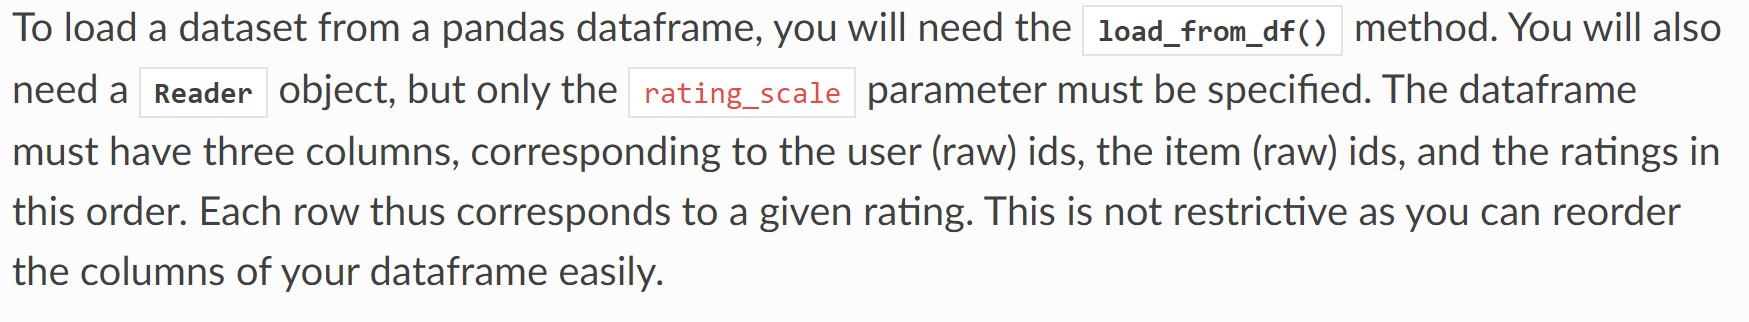The dataframe must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings in this order. 

In [ ]:
users=[]
for user in ratings.index:
  users.extend([user]*len(ratings.columns))
 
tracks = list(ratings.columns)*len(ratings.index)
score=[]
for i in range(len(ratings.index)):
  for j in range(len(ratings.columns)):
    score.append(float(ratings.iloc[i,j]))
temp={'users':users,'tracks':tracks,'score':score}
data = pd.DataFrame(temp)
display(data.head(50))

,users,tracks,score
0,도윤,Bye Bye Bye__NSYNC,1.0
1,도윤,This I Promise You - Radio Edit__NSYNC,0.0
2,도윤,It's Gonna Be Me__NSYNC,1.0
3,도윤,God Must Have Spent a Little More Time on You ...,1.0
4,도윤,I Want You Back - Radio Edit__NSYNC,0.0
5,도윤,Pop - Radio Version__NSYNC,1.0
6,도윤,Tearin' up My Heart - Radio Edit__NSYNC,1.0
7,도윤,Ciao Adios__Anne-Marie,0.0
8,도윤,Gary's Theme - Remastered__Bill Evans,1.0
9,도윤,Levels - Radio Edit__Avicii,0.0


In [ ]:
from sklearn.utils import shuffle
import random
reader = Reader(rating_scale=(-1, 1))
TRAIN_SIZE = 0.8
data = shuffle(data,random_state=3)
data = shuffle(data,random_state=33)

cutoff = int(TRAIN_SIZE * len(data))
ratings_train = data.iloc[:cutoff]
ratings_test = data.iloc[cutoff:]
display(ratings_train,ratings_test)

# The columns must correspond to user id, item id and ratings (in that order).
dataset = Dataset.load_from_df(data,reader)
Trainset = Dataset.load_from_df(ratings_train,reader)
Testset = Dataset.load_from_df(ratings_test,reader)
# Train/Test 분리
trainset,testset= train_test_split(dataset,train_size=0.8,random_state=3)
#len(trainset.all_items())

,users,tracks,score
727,도윤_Maya,No Vacancy__OneRepublic,-1.0
4517,윤지현,Beat It - Single Version__Michael Jackson,1.0
2813,정인,Started From the Bottom__Drake,-1.0
1629,헝록3,Levels - Radio Edit__Avicii,1.0
1359,형록1,Get Lucky - Daft Punk Remix__Daft Punk,1.0
...,...,...,...
1626,헝록3,Tearin' up My Heart - Radio Edit__NSYNC,-1.0
4102,근호,I Want You - Single Version__Marvin Gaye,1.0
2189,창현,Whippin (feat. Felix Snow)__Kiiara,0.0
2029,창현_승련,The One__The Chainsmokers,1.0


,users,tracks,score
143,도윤,Beat It - Single Version__Michael Jackson,1.0
2213,창현,Kyoto (feat. Sirah)__Skrillex,1.0
962,도윤_MI,SexyBack__Justin Timberlake,1.0
140,도윤,My Boo__Usher,1.0
3365,나윤3,"String Quintet in C Major, Op. 29: II. Adagio ...",-1.0
...,...,...,...
1208,도윤_Tiffany,Get Lucky__Daft Punk,0.0
1699,헝록3,No Vacancy__OneRepublic,1.0
2328,창현_세영,"Gone, Gone__Juicy J",-1.0
1569,형록2,What 2 Do__DEAN,1.0


### Coclustering

In [ ]:
from surprise import KNNWithMeans, KNNBaseline, KNNBasic, KNNWithZScore,CoClustering

In [ ]:
from surprise.model_selection import GridSearchCV

In [ ]:
from sklearn.utils import shuffle
import random
reader = Reader(rating_scale=(-1, 1))
TRAIN_SIZE = 0.8
data = shuffle(data,random_state=3)
data = shuffle(data,random_state=33)

cutoff = int(TRAIN_SIZE * len(data))
ratings_train = data.iloc[:cutoff]
ratings_test = data.iloc[cutoff:]
display(ratings_train,ratings_test)

# The columns must correspond to user id, item id and ratings (in that order).
dataset = Dataset.load_from_df(data,reader)
Trainset = Dataset.load_from_df(ratings_train,reader)
Testset = Dataset.load_from_df(ratings_test,reader)
# Train/Test 분리
trainset,testset= train_test_split(dataset,train_size=0.8,random_state=3)
#len(trainset.all_items())

In [ ]:
param_grid = {'n_cltr_u': [2,3,4,5,6,7,8], 'n_cltr_i': [2,3,4,5,6,7,8], 'n_epochs':[10,20,30,40,50,60,70,80]}

In [ ]:
grid_search = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=5,n_jobs=-1)

In [ ]:
grid_search.fit(Trainset)

In [ ]:
algo = grid_search.best_estimator['rmse']
algo.fit(trainset)

In [ ]:
print(grid_search.best_params)

{'rmse': {'n_cltr_u': 5, 'n_cltr_i': 2, 'n_epochs': 30}}


In [ ]:
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
display(results_df) # 행의 개수는 grid search 한 경우의 수

# Compute unbiased accuracy on teset
predictions = algo.test(testset)
print('Unbiased accuracy on Test,', end=' ')
round(accuracy.rmse(predictions),4)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_cltr_u,param_n_cltr_i,param_n_epochs
0,0.757955,0.767765,0.755011,0.772391,0.775175,0.765659,0.007913,92,0.039123,0.001089,0.007459,0.001443,"{'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 10}",2,2,10
1,0.754475,0.775985,0.749655,0.763507,0.765485,0.761821,0.009153,55,0.078243,0.011396,0.006821,0.000057,"{'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 20}",2,2,20
2,0.743974,0.774335,0.748844,0.769853,0.767269,0.760855,0.012108,42,0.101651,0.006371,0.006764,0.000250,"{'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 30}",2,2,30
3,0.762605,0.782246,0.751243,0.771034,0.763499,0.766125,0.010244,94,0.144213,0.019038,0.006781,0.000069,"{'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 40}",2,2,40
4,0.767054,0.772839,0.757572,0.765627,0.762333,0.765085,0.005066,81,0.234914,0.028272,0.006809,0.000187,"{'n_cltr_u': 2, 'n_cltr_i': 2, 'n_epochs': 50}",2,2,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0.796985,0.801020,0.765618,0.791994,0.794364,0.789996,0.012552,346,0.320415,0.043329,0.006916,0.000517,"{'n_cltr_u': 8, 'n_cltr_i': 8, 'n_epochs': 40}",8,8,40
388,0.789743,0.819382,0.784854,0.784980,0.787741,0.793340,0.013148,371,0.371929,0.034892,0.006708,0.000243,"{'n_cltr_u': 8, 'n_cltr_i': 8, 'n_epochs': 50}",8,8,50
389,0.798015,0.808507,0.816266,0.779670,0.789593,0.798410,0.013037,386,0.435624,0.025548,0.007481,0.001641,"{'n_cltr_u': 8, 'n_cltr_i': 8, 'n_epochs': 60}",8,8,60
390,0.768294,0.802896,0.782572,0.803335,0.810828,0.793585,0.015748,373,0.502768,0.038432,0.008241,0.002973,"{'n_cltr_u': 8, 'n_cltr_i': 8, 'n_epochs': 70}",8,8,70


Unbiased accuracy on Test, RMSE: 0.7479


0.7479